In [4]:
import numpy as np 
from matplotlib import pyplot as plt
from skimage import color, filters
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from skimage.io import imread
from numpy import logspace
import os
import pandas as pd
from skimage.transform import resize, rotate
import pickle as pkl


##### **Image Preprocessing, Augmentation, and Feature Extraction function declaration**

In [5]:
def augment_image(image):
    augmented_images = []
    augmented_images.append(image)  # Original
    augmented_images.append(np.fliplr(image))  # Horizontal flip
    augmented_images.append(np.flipud(image))  # Vertical flip
    augmented_images.append(rotate(image, angle=15, mode='edge'))  # 15 degrees rotation
    augmented_images.append(rotate(image, angle=-15, mode='edge')) # -15 degrees rotation
    return augmented_images

def preprocess_image(image):
    if image.shape[-1] == 4: # If the image has 4 channels, change it to 3 channels
        image = image[:, :, :3] 
    gray_image = color.rgb2gray(image) # RGB to Grayscale
    blurred_image = filters.gaussian(gray_image, sigma=1) # Gaussian blur
    normalized_image = blurred_image / 255.0 # Image Normalization: [0, 255] to [0, 1]
    return normalized_image

# LBP Parameters
LBP_RADIUS = 3 # Radius of the circle to be considered in the LBP
LBP_POINTS = 8 * LBP_RADIUS # Number of points to be considered in the LBP

# HOG Parameters
HOG_PARAMS = {
    'orientations': 8, # Number of bins in the histogram
    'pixels_per_cell': (16, 16), # Size of the cell
    'cells_per_block': (2, 2), # Number of cells in each block
    'block_norm': 'L2-Hys'
}

def extract_features(image):
    lbp = local_binary_pattern(image, LBP_POINTS, LBP_RADIUS, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), density=True)

    hog_features = hog(image, **HOG_PARAMS)

    # Combine LBG and HoG features
    combined_features = np.hstack((lbp_hist, hog_features))
    return combined_features

# **Data Acquisition and Data Preprocessing**

In [6]:
# Dataset root directory
image_dir = 'garbage'

# Image Classes in the dataset
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

features = []
labels = []

for label in classes:
    class_dir = os.path.join(image_dir, label)
    print(class_dir)
    image_files = os.listdir(class_dir)
    
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        image = imread(image_path)
        image = preprocess_image(image)
        augmented_images = augment_image(image)
        print(f"Processing image {idx + 1}/{len(image_files)}", end='\r')
    
        for aug_image in augmented_images:
            image_features = extract_features(aug_image)
            features.append(image_features)
            labels.append(label)

garbage\cardboard
garbage\glassage 403/403
garbage\metalage 501/501
garbage\paperage 410/410
garbage\plastice 594/594
garbage\trashage 482/482


# **Data Splitting and Dimensionality Reduction**

In [7]:
features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

print(X_train.shape) 
print(X_test.shape)

pca = PCA(n_components=70) # Reduce the dimension from 22842 to 70 to increase model efficiency
X_pca = pca.fit_transform(features)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

(10108, 22842)
(2527, 22842)


# **Model Training and Evaluation**

### **SVM**

In [8]:
svm = SVC()
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Hyperparameter Tuning
params = {
    # Regularization parameter
    'C': logspace(-4, 4, 9),  # [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    
    # Kernel selection
    'kernel': ['rbf', 'poly', 'sigmoid'],

    # Kernel coefficient
    'gamma': ['scale', 'auto'] + list(logspace(-4, 2, 7)),  # More fine-grained gamma values
    
    # Polynomial kernel specific parameters
    'degree': [2, 3, 4],
    'coef0': [0, 1, 2],
    
    # Class weight handling (Balanced is used for imbalanced datasets)
    'class_weight': ['balanced', None],
    
    # Numerical tolerance
    'tol': [1e-3, 1e-4],
    
    # Memory optimization
    'cache_size': [2000],

    # Decision function shape (we use ovr because our task is about multi class classification)
    'decision_function_shape': ['ovr'],
}

# Perform randomized search CV
rs_svm = RandomizedSearchCV(svm, params, cv=skf, n_jobs=-1, verbose=1, random_state=42, n_iter=50)
rs_svm.fit(X_train_pca, y_train)
svm = rs_svm.best_estimator_

svm.fit(X_train_pca, y_train)
print(rs_svm.best_params_)
y_pred_svm = svm.predict(X_test_pca)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'tol': 0.0001, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'decision_function_shape': 'ovr', 'coef0': 2, 'class_weight': 'balanced', 'cache_size': 2000, 'C': np.float64(10.0)}
Test Set Accuracy: 0.7431737237831421
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.79      0.75      0.77       403
       glass       0.67      0.76      0.71       501
       metal       0.73      0.68      0.70       410
       paper       0.81      0.84      0.83       594
     plastic       0.68      0.69      0.69       482
       trash       0.93      0.62      0.75       137

    accuracy                           0.74      2527
   macro avg       0.77      0.72      0.74      2527
weighted avg       0.75      0.74      0.74      2527



In [22]:
print(f"Test Score: {round(svm.score(X_test_pca, y_test), 4)}")
print(f"Weighted Precision: {round(precision_score(y_test, y_pred_svm, average='weighted'), 4)}")
print(f"Weighted Recall: {round(recall_score(y_test, y_pred_svm, average='weighted'), 4)}")
print(f"Weighted F1-Score: {round(f1_score(y_test, y_pred_svm, average='weighted'), 4)}")

Test Score: 0.7432
Weighted Precision: 0.7486
Weighted Recall: 0.7432
Weighted F1-Score: 0.7432


In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svm, X_pca, labels, cv=skf)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: [0.74910962 0.73288484 0.75702414 0.74159082 0.74396518]
Mean CV score: 0.745 (+/- 0.016)


<Figure size 800x600 with 0 Axes>

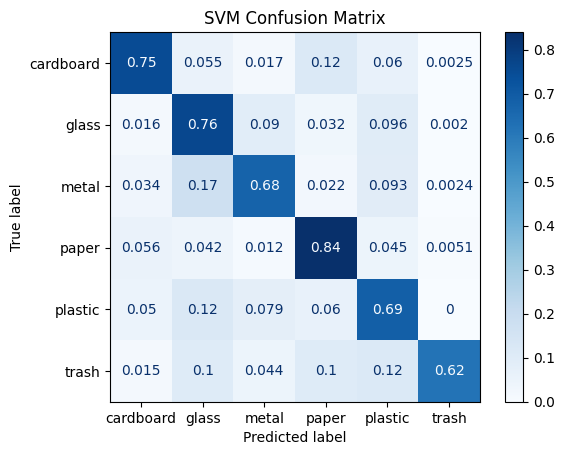

In [12]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rs_svm.best_estimator_, X_test_pca, y_test, display_labels=classes, cmap=plt.cm.Blues, normalize='true')
plt.title('SVM Confusion Matrix')
plt.show()

### **KNN**

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights='distance')
params = {
    # Number of neighbors
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        
    # Algorithm
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    
    # Leaf size for BallTree or KDTree
    'leaf_size': [20, 30, 40, 50],
    
    # Power parameter (1 = Manhattan distance, 2 = Euclidean distance)
    'p': [1, 2],
    
    # Distance Metric
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
}

rs_knn = RandomizedSearchCV(knn, params, cv=skf, n_jobs=-1, verbose=1, random_state=42, n_iter=50)

rs_knn.fit(X_train_pca, y_train)
knn = rs_knn.best_estimator_
knn.fit(X_train_pca, y_train)
print(rs_knn.best_params_)
y_pred_knn = knn.predict(X_test_pca)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'p': 1, 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 50, 'algorithm': 'ball_tree'}
Test Set Accuracy: 0.6909378709932726
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.62      0.84      0.71       403
       glass       0.71      0.66      0.68       501
       metal       0.70      0.57      0.63       410
       paper       0.78      0.72      0.75       594
     plastic       0.62      0.67      0.64       482
       trash       0.79      0.68      0.73       137

    accuracy                           0.69      2527
   macro avg       0.70      0.69      0.69      2527
weighted avg       0.70      0.69      0.69      2527



In [23]:
print(f"Test Score: {round(knn.score(X_test_pca, y_test), 4)}")
print(f"Weighted Precision: {round(precision_score(y_test, y_pred_knn, average='weighted'), 4)}")
print(f"Weighted Recall: {round(recall_score(y_test, y_pred_knn, average='weighted'), 4)}")
print(f"Weighted F1-Score: {round(f1_score(y_test, y_pred_knn, average='weighted'), 4)}")

Test Score: 0.6909
Weighted Precision: 0.6993
Weighted Recall: 0.6909
Weighted F1-Score: 0.6904


In [15]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn, X_pca, labels, cv=skf)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: [0.70557974 0.6853977  0.70755837 0.70122675 0.69252078]
Mean CV score: 0.698 (+/- 0.017)


<Figure size 800x600 with 0 Axes>

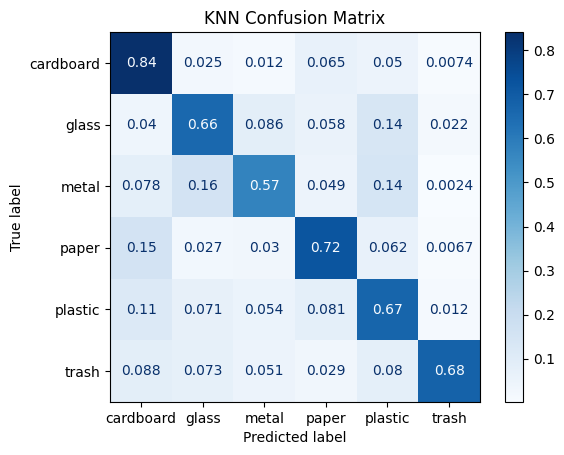

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rs_knn.best_estimator_, X_test_pca, y_test, display_labels=classes, cmap=plt.cm.Blues, normalize='true')
plt.title('KNN Confusion Matrix')
plt.show()

### **Random Forest**

In [17]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
params = {
    # Number of trees
    'n_estimators': [50, 100, 200, 300, 400, 500], 
    # Maximum number of levels/depth in each tree
    'max_depth': [3, 4, 5, 6],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],  
    # Method of selecting samples for training each tree
    'bootstrap': [True]
}

rs_rf= RandomizedSearchCV(rf, params, cv=skf, n_jobs=-1, verbose=1, random_state=42, n_iter=50)
rs_rf.fit(X_train_pca, y_train)
rf = rs_rf.best_estimator_
rf.fit(X_train_pca, y_train)
print(rs_rf.best_params_)
y_pred_rf = rf.predict(X_test_pca)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 6, 'bootstrap': True}
Test Set Accuracy: 0.5033636723387416
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.60      0.64      0.62       403
       glass       0.48      0.46      0.47       501
       metal       0.46      0.42      0.44       410
       paper       0.66      0.55      0.60       594
     plastic       0.41      0.43      0.42       482
       trash       0.31      0.55      0.40       137

    accuracy                           0.50      2527
   macro avg       0.49      0.51      0.49      2527
weighted avg       0.52      0.50      0.51      2527



In [24]:
print(f"Test Score: {round(rf.score(X_test_pca, y_test), 4)}")
print(f"Weighted Precision: {round(precision_score(y_test, y_pred_rf, average='weighted'), 4)}")
print(f"Weighted Recall: {round(recall_score(y_test, y_pred_rf, average='weighted'), 4)}")
print(f"Weighted F1-Score: {round(f1_score(y_test, y_pred_rf, average='weighted'), 4)}")

Test Score: 0.5034
Weighted Precision: 0.5165
Weighted Recall: 0.5034
Weighted F1-Score: 0.5067


In [19]:
from sklearn.model_selection import cross_val_score

# After finding best model
cv_scores = cross_val_score(rf, X_pca, labels, cv=skf)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: [0.51167392 0.51365255 0.5128611  0.52433716 0.52908587]
Mean CV score: 0.518 (+/- 0.014)


<Figure size 800x600 with 0 Axes>

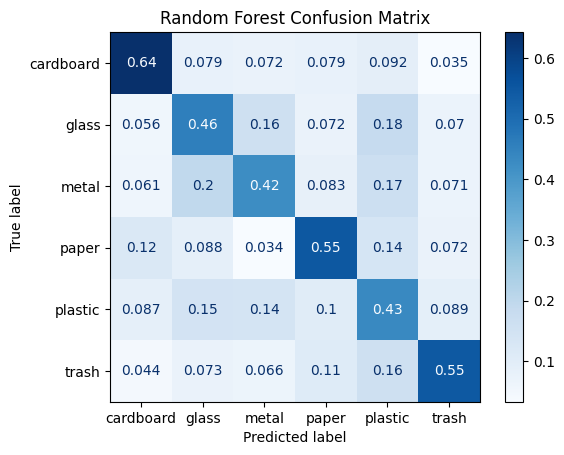

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rs_rf.best_estimator_, X_test_pca, y_test, display_labels=classes, cmap=plt.cm.Blues, normalize='true')
plt.title('Random Forest Confusion Matrix')
plt.show()

# **Export Model**

In [21]:
pkl.dump(svm, open('models/svm_model.pkl', 'wb'))
pkl.dump(knn, open('models/knn_model.pkl', 'wb'))
pkl.dump(rf, open('models/rf_model.pkl', 'wb'))
pkl.dump(pca, open('models/pca_model.pkl', 'wb'))